In [ ]:
%run D:\codes\wrf_helen\read_wrf_helen.ipynb
%run D:\codes\confg

In [1]:
%%capture
"""Compare different models (ICON, AROME, UKMO, WRF_ACINN) with radiosonde, in one plot with pressure as y-variable"""
import warnings

import xarray as xr

import metpy
import metpy.calc as mpcalc
import numpy as np
import pandas as pd
import wrf
from matplotlib import pyplot as plt
from metpy.plots import SkewT
from metpy.units import units
from netCDF4 import Dataset

    
warnings.filterwarnings("ignore")

In [2]:
# Specify the launch date and time
launch_date = pd.to_datetime('2017-10-16 02:15:05',
                             format='%Y-%m-%d %H:%M:%S')

time_for_model = pd.to_datetime('2017-10-16 03:00:00',
                                format='%Y-%m-%d %H:%M:%S')  # TODO can change here the time
#time_for_model = ds

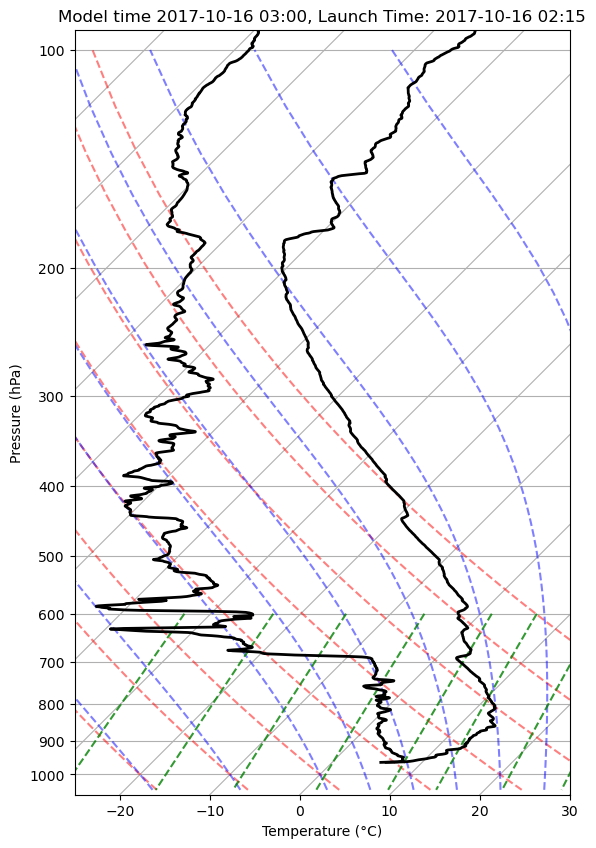

In [6]:
#OBS
def read_in_radiosonde_obs():
    """read csv and plot the radiosonde observation of the airport of ibk"""
    df = pd.read_csv(radiosonde_csv, comment="#")

    # Drop rows with NaN values in any column
    df_cleaned = df.dropna()

    # Convert 'time' from seconds since launch to actual datetime
    df_cleaned['time'] = pd.to_timedelta(df_cleaned['time'], unit='s') + launch_date

    # convert also the units of some other variables
    df_cleaned.loc[:, 'pressure'] = df.loc[df_cleaned.index, 'pressure'] / 100
    df_cleaned.loc[:, 'dewpoint'] = df.loc[df_cleaned.index, 'dewpoint'] - 273.15
    df_cleaned.loc[:, 'temperature'] = df.loc[df_cleaned.index, 'temperature'] - 273.15

    df_unique = df_cleaned.drop_duplicates(['time', 'geopotential height'])

    # Then set the index and convert to xarray
    df_unique.set_index(['time'], inplace=True)

    u = df_unique["windspeed"].values * units.meter / units.second

    p = df_unique['pressure'].values * units.hPa
    T = df_unique['temperature'].values * units.degC
    Td = df_unique['dewpoint'].values * units.degC
    wind_speed = u.to(units.knots)
    wind_dir = df_unique['wind direction'].values * units.degrees
    u, v = mpcalc.wind_components(wind_speed, wind_dir)
    z = df_unique["geopotential height"].values * units.meter

    ds = xr.Dataset()

    # Add variables to the dataset
    ds['u_wind'] = xr.DataArray(u.magnitude, dims=('height',),
                                coords={'height': df_unique["geopotential height"].values},
                                attrs={'units': str(u.units)})
    ds['v_wind'] = xr.DataArray(v.magnitude, dims=('height',),
                                coords={'height': df_unique["geopotential height"].values},
                                attrs={'units': str(v.units)})
    ds['pressure'] = xr.DataArray(p.magnitude, dims=('height',),
                                  coords={'height': df_unique["geopotential height"].values},
                                  attrs={'units': str(p.units)})
    ds['temperature'] = xr.DataArray(T.magnitude, dims=('height',),
                                     coords={'height': df_unique["geopotential height"].values},
                                     attrs={'units': str(T.units)})
    ds['dewpoint'] = xr.DataArray(Td.magnitude, dims=('height',),
                                  coords={'height': df_unique["geopotential height"].values},
                                  attrs={'units': str(Td.units)})

    return ds.metpy.quantify()


df_obs = read_in_radiosonde_obs()


#PLOT

fig = plt.figure(figsize=(9,9))

skew = SkewT(fig, rotation=45, rect=(0.1, 0.1, 0.55, 0.85))


skew.plot(df_obs["pressure"].values, df_obs["temperature"].values, color=colordict["RADIOSONDE"],
          label="Observation", linewidth=2)
skew.plot(df_obs["pressure"].values, df_obs["dewpoint"].values, color=colordict["RADIOSONDE"], linewidth=2)

# Change to adjust data limits and give it a semblance of what we want
skew.ax.set_adjustable('datalim')

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

plt.title(
    f"Model time {pd.to_datetime(time_for_model).strftime('%Y-%m-%d %H:%M')}, Launch Time: {pd.to_datetime(launch_date).strftime('%Y-%m-%d %H:%M')}")

skew.ax.set_xlabel('Temperature (°C)')
skew.ax.set_ylabel('Pressure (hPa)')
skew.ax.set_xlim(-25, 30)
skew.ax.set_ylim(1000, 100)

plt.savefig("D:/plots/obs_radiosounding.png")


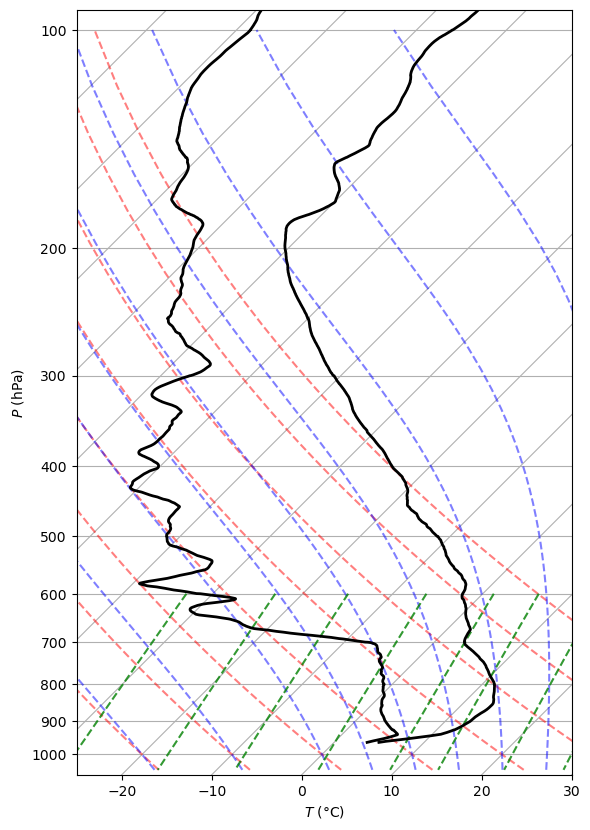

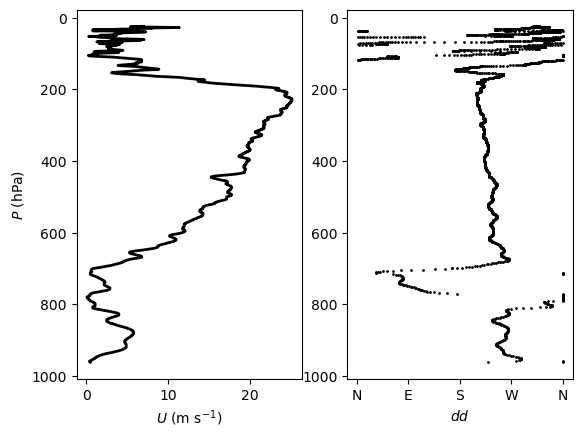

In [8]:
#PLOT CONVOLVE

fig = plt.figure(figsize=(9,9))

skew = SkewT(fig, rotation=45, rect=(0.1, 0.1, 0.55, 0.85))


skew.plot(df_obs["pressure"].values, np.convolve(np.ones(35)/35, df_obs["temperature"].values, 'same'), 
          color='k', linewidth=2)
skew.plot(df_obs["pressure"].values, np.convolve(np.ones(35)/35, df_obs["dewpoint"].values, 'same'), 
          color='k', linewidth=2)
#skew.plot_barbs(obs_p4, obs_u, obs_v)
# Change to adjust data limits and give it a semblance of what we want
skew.ax.set_adjustable('datalim')

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

# plt.title(
#     f"Model time {pd.to_datetime(time_for_model).strftime('%Y-%m-%d %H:%M')}, Launch Time: {pd.to_datetime(launch_date).strftime('%Y-%m-%d %H:%M')}")

skew.ax.set_xlabel('$T$ (°C)')
skew.ax.set_ylabel('$P$ (hPa)')
skew.ax.set_xlim(-25, 30)
skew.ax.set_ylim(1000, 100)

plt.savefig("D:/plots/obs_radiosounding_convoluted.svg")
plt.savefig("D:/plots/obs_radiosounding_convoluted.png")


#plt.legend()

fig, axarr = plt.subplots(nrows=1, ncols=2)
axlist = axarr.flatten()

ff_obs = mpcalc.wind_speed(df_obs["u_wind"], df_obs["v_wind"]).values * 0.514444
dd_obs = mpcalc.wind_direction(df_obs["u_wind"], df_obs["v_wind"])

axlist[0].plot(ff_obs, df_obs['pressure'], color=colordict["RADIOSONDE"], linewidth=2)

axlist[0].invert_yaxis()
# ax.set_yscale('log')
axlist[0].set_ylabel("$P$ (hPa)")
axlist[0].set_xlabel(r"$U$ (m s$^{-1}$)")
#axlist[0].set_title("Wind speed")
#axlist[0].legend()
#axlist[0].grid(True)

axlist[1].plot(dd_obs, df_obs['pressure'], '.',markersize=2, color=colordict["RADIOSONDE"], linewidth=2)
axlist[1].invert_yaxis()
# ax.set_yscale('log')
#axlist[1].set_ylabel("Pressure (hpa)")
axlist[1].set_xlabel("$dd$")
#axlist[1].set_title("Wind direction")
#axlist[1].grid(True)
xticks = np.arange(0, 361, 90)
xtick_labels = ['N', 'E', 'S', 'W', 'N']
axlist[1].set_xticks(xticks)
axlist[1].set_xticklabels(xtick_labels)

plt.savefig("D:/plots/obs_wind.svg")


# WRF_ACINN

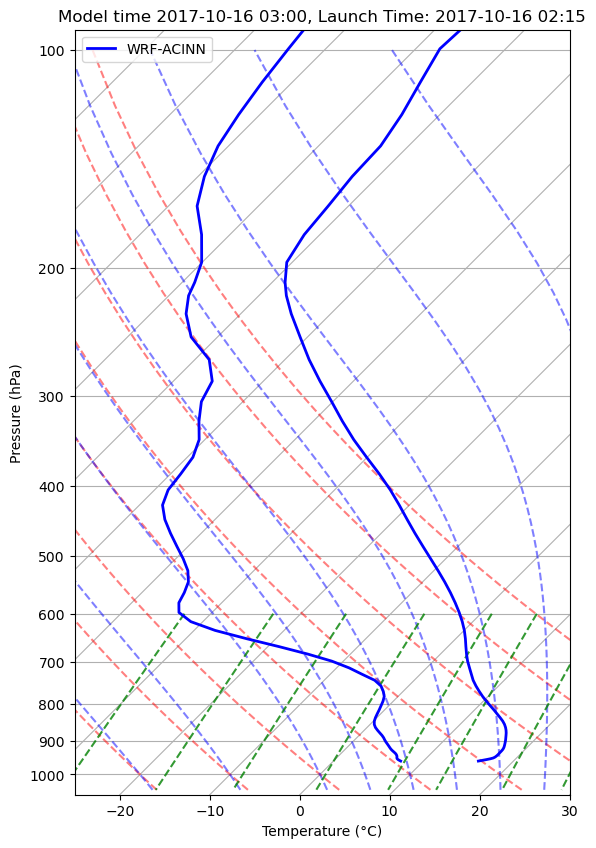

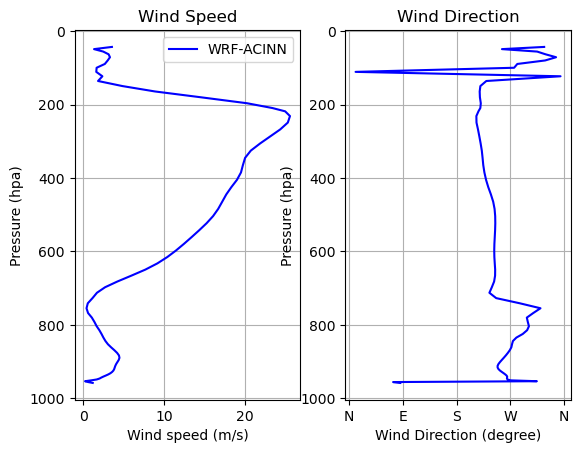

In [9]:
#WRF_ACINN

def read_radiosonde_wrf_acinn():
    """read in radiosonde data from WRF ACINN"""
    df_acinn = read_wrf_fixed_point_and_time(day=16, hour=3, minute=0, latitude=station_files_zamg["LOWI"]["lat"],
                                             longitude=station_files_zamg["LOWI"]["lon"])
    return df_acinn

df_wrf_acinn = read_radiosonde_wrf_acinn()

fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=45, rect=(0.1, 0.1, 0.55, 0.85))

skew.plot(df_wrf_acinn["pressure"].values, df_wrf_acinn["temperature"].values, color=colordict["WRF_ACINN"], label="WRF-ACINN",linewidth=2)
skew.plot(df_wrf_acinn["pressure"].values, df_wrf_acinn["dewpoint"].values, color=colordict["WRF_ACINN"],linewidth=2)


# Change to adjust data limits and give it a semblance of what we want
skew.ax.set_adjustable('datalim')

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

plt.title(
    f"Model time {pd.to_datetime(time_for_model).strftime('%Y-%m-%d %H:%M')}, Launch Time: {pd.to_datetime(launch_date).strftime('%Y-%m-%d %H:%M')}")

skew.ax.set_xlabel('Temperature (°C)')
skew.ax.set_ylabel('Pressure (hPa)')
skew.ax.set_xlim(-25, 30)
skew.ax.set_ylim(1000, 100)

plt.legend()

plt.savefig("D:/plots/wrf_acinn_radiosounding")



fig, axarr = plt.subplots(nrows=1, ncols=2)
axlist = axarr.flatten()

ff_wrf_helen = mpcalc.wind_speed(df_wrf_acinn["u"], df_wrf_acinn["v"])
dd_wrf_helen = mpcalc.wind_direction(df_wrf_acinn["u"], df_wrf_acinn["v"])


axlist[0].plot(ff_wrf_helen, df_wrf_acinn["pressure"], label="WRF-ACINN", color=colordict["WRF_ACINN"])


axlist[0].invert_yaxis()
# ax.set_yscale('log')
axlist[0].set_ylabel("Pressure (hpa)")
axlist[0].set_xlabel("Wind speed (m/s)")
axlist[0].set_title("Wind Speed")
axlist[0].legend()
axlist[0].grid(True)
    
    
axlist[1].plot(dd_wrf_helen, df_wrf_acinn["pressure"], label="WRF-ACINN", color=colordict["WRF_ACINN"])

axlist[1].invert_yaxis()
# ax.set_yscale('log')
axlist[1].set_ylabel("Pressure (hpa)")
axlist[1].set_xlabel("Wind Direction (degree)")
axlist[1].set_title("Wind Direction")
axlist[1].grid(True)
xticks = np.arange(0, 361, 90)
xtick_labels = ['N', 'E', 'S', 'W', 'N']
axlist[1].set_xticks(xticks)
axlist[1].set_xticklabels(xtick_labels)


plt.savefig("D:/plots/wrf_acinn_wind")